# ANLP Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [1]:
candidateno=237740
print(f'This scored 35/40, which i feel was rather harsh')

This scored 35/40, which i feel was rather harsh


In [25]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI

[nltk_data] Downloading package punkt to /home/shmott/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/shmott/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/shmott/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [26]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 
def get_train_test_data():
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [27]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

### 1. Preprocessing code:

In [5]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def normalise(tokenlist):
    # if token contains only digits -> 'NUM'
    tokenlist=["NUM" if token.isdigit() else token for token in tokenlist]
    # token contains cardinal -> 'Nth'
    tokenlist=["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in tokenlist]
    # more normalising of different number and special character combos
    tokenlist=["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in tokenlist]
    tokenlist=[token.lower() for token in tokenlist]
    return tokenlist

def filter_stopwords(tokenlist):
    """
    filter stopwords and punctuation
    """
    tokenlist = [t for t in tokenlist if t not in stopwords.words('english') and t.isalpha()]
    return tokenlist

def pre_process(data):
    """
    Pre-process the given data
    """
    # apply lower casing, eliminate stopwords and numbers
    pre_process_docs = [(filter_stopwords(normalise(doc)), label) for (doc,label) in data]
    
    # apply lemmatisation using speech tagging
    pre_process_docs = [(FreqDist([wnl.lemmatize(word) for word in doc]), label) for (doc,label) in pre_process_docs]
    
    return pre_process_docs 

### 1.0 Initial preprocessing

In [6]:
# pre-process training and test data
training_norm = pre_process(training_data)
testing_norm = pre_process(testing_data)

## 1(a,b): Code for Generating Content words

In [28]:
def generate_content_words(data, k):
    # frequency distribution for both classes
    posfreq, negfreq = freq_dists(data)
            
    # grab the most frequent words for both classes, retaining frequency
    mf_posfreq = most_frequent_words(posfreq, negfreq, k)
    mf_negfreq = most_frequent_words(negfreq, posfreq, k)
    
    data = [mf_posfreq,
            mf_negfreq,
            posfreq.most_common(k),
            negfreq.most_common(k)]
    
    return data

# most frequent words between two frequency distributions
def most_frequent_words(posfreq, negfreq, k):
    return (posfreq-negfreq).most_common(k)

def freq_dists(data):
    '''
    Returns a frequency distribution based
    on the labels in the training data and their 
    corresponding word features
    '''
    posfreq = FreqDist()
    negfreq = FreqDist()

    # iterate data arg
    for review, label in data:
        # only two possible values, one check required
        if label == 'pos':
            posfreq += FreqDist(review)
        else:
            negfreq += FreqDist(review)
            
    return posfreq, negfreq

### Generating ten content words for both of the class labels

In [29]:
k = 10 #  wordlist length

# generate content words based on frequency differences
mf_pos, mf_neg, posfreq, negfreq = generate_content_words(training_norm, k)

# Store labels of each class 
columns = ['pos content words', 'freq',
           'neg content words', 'freq',
           'all_pos_freq', 'freq',
           'all_neg_freq', 'freq']

# Store each list of pos and neg dists and thier respective k most frequent words
data = []
for i in range(k):
    data.append((mf_pos[i][0], mf_pos[i][1],
                 mf_neg[i][0], mf_neg[i][1],
                 posfreq[i][0], posfreq[i][1], 
                 negfreq[i][0], negfreq[i][1]))

# Display results with pandas dataframe
freq_df = pd.DataFrame(data=data, columns=columns)
display(freq_df) 

,pos content words,freq,neg content words,freq,all_pos_freq,freq,all_neg_freq,freq
0,film,891,bad,446,film,4286,film,3395
1,life,405,movie,381,movie,2352,movie,2733
2,also,338,plot,207,one,2221,one,1947
3,one,274,worst,141,num,1972,num,1920
4,best,270,nothing,130,character,1467,like,1350
5,great,264,look,127,like,1334,character,1220
6,performance,260,minute,123,time,1067,get,1034
7,story,257,stupid,121,scene,985,time,990
8,character,247,could,120,make,962,even,957
9,well,243,boring,114,get,953,scene,875


## 1c: Explanation

Initial pre-processing steps were undertaken upon the movie review data set. Given the data is in list form and tokenised, the operations were focused on normalising the training and testing datasets by altering the cardinal and ordinal numbers in every feature to 'NUM' and 'Nth' respectively. Furthermore, all words were lower cased in order to avoid multiple occurances of the same word. This could cause a duplicate in regards to the k most frequent words lists if enough of a capitalised variant of a word occurs. In terms of the function call to 'normalise' in the list comprehension within the 'pre_process' function, this returns a list which is passed to the filter method. Here, the check on each token is undertaken against the english stop words provided by NLTK. The additional conditional statement implemented via Python's string method 'isaplha' essentially removes punctuation along with any other token comprised of a non character. These processing steps are based upon the fact that punctuation and stopwords do not pertain to a positive or negative sentiment. In the second phase of pre-processing, the NLTK lemmanisation library was used to look beyond word reduction and consider the language’s full vocabulary to apply a morphological analysis to the words in the data, aiming to remove inflectional endings only and to return the base or dictionary form of a word.

The generation of the content words for determining the negative and positive sentiment of a document were generated using the normalised training data. The documents were split into two separate frequency distributions based upon the documents class label then the greatest frequency difference was calculated for both class labels and the top ten of these were taken for the content words.

2) 
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


## 2a: Wordlist Classifier Code

In [30]:
class SimpleClassifier(ClassifierI): 

    def __init__(self, k): 
        self._pos = []
        self._neg = []
        self.k = k
        
    def classify(self, doc): 
        
        score = 0
        # iterate over key, value pairs in doc (freq dist)
        for word, freq in doc.items():
            if word in self._pos:
                score+=1 # increment if word in pos list
            elif word in self._neg:
                score-=1 # decrement if word in neg list
                
        # check if score is 0
        if not score:
            return 'neg' if random.random() < 0.5 else 'pos'
            
        return 'neg' if score < 0 else 'pos'

    def labels(self): 
        return ('pos', 'neg')
    
    def most_freq_words(self, posfreq, negfreq):
        '''
        greatest frequency difference between two dist 
        returning k most frequent upon the calculation
        '''
        return [w for w,_ in (posfreq-negfreq).most_common(self.k)]
    
    def train(self, data):
        
        pos_freq_dist = FreqDist()
        neg_freq_dist = FreqDist()

        # collect word frequency distribution for class labels
        for review, label in data:
            if label == 'pos':
                pos_freq_dist += FreqDist(review)
            else:
                neg_freq_dist += FreqDist(review)
        
        # fetch the most frequent words difference for each class label
        self._pos = self.most_freq_words(pos_freq_dist, neg_freq_dist)
        self._neg = self.most_freq_words(neg_freq_dist, pos_freq_dist)
        
wordlist_classifier = SimpleClassifier(k)
wordlist_classifier.train(training_norm)

## 2b: code explanation

The simple word classifier class contains four methods. The train method utilises the NLTK FreqDist method to collect the frequency of every word for the different class labels within the normalised training dataset. The 'most_frequent_words' method is called in the training process and uses the two class label word frequency distributions to calculate their respective greatest frequency difference distributions. The given k parameter is set to ten. This produces the same output of content words shown in question 1(a/b) and is set to a class variable respective to its class label. The 'classify' function takes a frequency distribution and iteratates over every word and its frequency (key, value) and checks if the word is in either of the positive or negative lists. Here, the score is either incremented by 1 for a positive hit or decremented by 1 for negative hit. If the word is not contained within either of the word lists then the score is left untouched. If after the document has been iterated fully through and the score is equal to zero then one class is randomly drawn.

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

## 3a: Code

In [31]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=('pos','neg')):
    
        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1: #  Both true and pred are correct
                    self.TP+=1
                else:
                    self.FN+=1 # 
        
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
                
    def accuracy(self):
        acc = (self.TP+self.TN)/(self.FP+self.TP+self.FN+self.TN)
        return acc
    
    def precision(self):
        '''
        The proportion of +ve predictions that are correct
        '''
        p=0
        p = self.TP/(self.TP+self.FP)
        return p
  
    def recall(self):
        '''
        The proportion of actually documents +ve that are predicted correctly
        '''
        r=0
        r = self.TP/(self.TP+self.FN)
        return r
  
    def f1(self):
        '''
        in general, we want both precision and recall to be high
        This is the harmonic mean (and is always closer to the lower
        of the two values)
        '''
        f1=0
        p = self.precision()
        r = self.recall()
        f1=(2*p*r)/(p+r)
        return f1 
    
    def get_all(self):
        return self.accuracy(), self.f1(), self.precision(), self.recall()
    
    def get_matrix(self):
        columns = ['Negative', 'Positive']
        cm_data = [[self.TN, self.FP], [self.FN, self.TP]]
        return pd.DataFrame(cm_data, index=columns, columns=columns)

In [32]:
def display_metrics(cms, index=None):
    columns = ['accuracy', 'F1', 'precision', 'recall']
    # loop through each confusion matrix and collect the metrics using the class methods
    cm_data = [[cm.accuracy(), cm.f1(), cm.precision(), cm.recall()] for cm in cms]
    return pd.DataFrame(cm_data, index=index, columns=columns) # return dataframe

def classifier_evaluate(cls, test_data):
    docs,true=zip(*test_data) #  grab test docs and the true label
    predictions=cls.classify_many(docs) # predict 
    return predictions, true

## 3a. Code Desciption

The confusion matrix class consists of six additional methods on top of the default initialising method. When instanciated, the true positive, false positive, true negative, and false negative are calculated from the given predictions and true labels. 
The methods:
accuracy: the percentage of correct predictions of the classifier, 
precision: the percentage of positive predictions the classifier got correct,
recall: the amount of actual positives the classifier predicts positive,
F1: the balance between precision and recall.

### 3a. Wordlist  classifier metrics

In [33]:
preds_test, gold = classifier_evaluate(wordlist_classifier, testing_norm)
wl_cm = ConfusionMatrix(preds_test, gold)
wl_mets = display_metrics([wl_cm], index = ['Wordlist Classifier'])
display(wl_mets)

,accuracy,F1,precision,recall
Wordlist Classifier,0.596667,0.701235,0.556863,0.946667


In [34]:
wl_matrix = wl_cm.get_matrix()
display(wl_matrix)

,Negative,Positive
Negative,74,226
Positive,16,284


## 3b:

The accuracy of the wordlist classifier is around 0.035 off 60%, which is an improvement of nearly 10% on a random selection. Although, the precision indicates the classifier lacks the ability to distinguish positive sentiment. This is most likely down to the fact that the positive word list contains high frequency words from both class label distributions and results in negative documents being classified as positive. In regards to this, the classifier would score a higher accuracy if there was a significant inbalance towards positive sentiment reviews in the test data. For example, if 500/600 of the reviews were positive and 100/600 negative, with the current classifier the accuracy would be deceptively high due to its tendency towards false positives. Additionally, the importance of accuracy varys on what the classifier is predicting. If trying to predict cancerous tumors in people, false negatives are more servere than a false positives.  

### Top ten frequent words and their position in the classes greatest frequency difference:

In [35]:
# difference between two frequency distributions
def difference(posfreq, negfreq):
    return posfreq-negfreq

def index_words(wordlist, data):
    '''
    indexing given words in the difference distributions,
    returns the words and its frequency within each dist
    '''
    posfreq, negfreq = freq_dists(data)
    posdiff = difference(posfreq, negfreq)
    negdiff = difference(negfreq, posfreq)
    return [[w, posdiff[w], negdiff[w]] for w in wordlist]

def occur_inboth(posfreq, negfreq):
    '''
    Words that occur in both of the top 10 words pos/neg distrubutions
    and there values after the difference calculations
    '''
    return [k for (k,v) in posfreq if k in dict(negfreq).keys()]

In [36]:
mf_inboth = index_words(occur_inboth(posfreq, negfreq), training_norm)
both_df = pd.DataFrame(data=mf_inboth, columns=['words', 'posfreq', 'negfreq'])
display(both_df) 

,words,posfreq,negfreq
0,film,891,0
1,movie,0,381
2,one,274,0
3,num,52,0
4,character,247,0
5,like,0,16
6,time,77,0
7,scene,110,0
8,get,0,81


The table above confirms the assertion made in 3b and shows the highest frequency words that occur in both the class label distributions and their resulting frequency once their differences have been calculated. As seen, the positive word list contains more of the most frequent words in both class label distributions, pushing the classifier to predict more positive outcomes when the word lists are smaller.

4) 
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results. 

[12.5\%]

## 4a:  Naive Bayes Classification

### Feature extraction:

In [14]:
# as we assume the testing data to be unknown, only get the vocab from training 
#vocab = FreqDist([w.lower() for w in r for r,_ in training_data])
def get_vocab(data):
    vocab = FreqDist()
    for r, _ in data:
        vocab+=r
    return list(vocab.keys())

# return the features and associated label for each document
def get_features(data):
    return [(find_features(rev), category) for (rev, category) in data]

# creates a FreqDist({word: boolean}): True if a word from vocab is in the document, else False
def find_features(document):
    words = set(document) # grabs only keys from dict
    return FreqDist({w:w in words for w in vocab})

vocab = get_vocab(training_norm)
featuresets = get_features(training_norm)
testsets = get_features(testing_norm)

# import nltk classifier
from nltk import NaiveBayesClassifier #  posterior occurences * liklihood / evidence
naive_classifier = NaiveBayesClassifier.train(featuresets)
preds_nc = [naive_classifier.classify(doc) for doc,label in testsets]

The NLTK Naive Bayes classifier method implements a multinomial Naive Bayes but only allows binary features. Hence, it requires the normalised training and testing data to have their features extracted. This is achieved by creating a known vocabulary list from the normalised training data which is used to determine if a word in a document is present or not. This comes into effect when features are being extracted from unlabelled reviews as words will be ignored by the classifier if false.

## 4b: Comparison with Wordlist CLassifier

### Metric comparison:

In [15]:
nb_cm = ConfusionMatrix(preds_nc, gold)
nb_metrics = display_metrics([wl_cm,nb_cm], index = ['Wordlist classifier', 'Naive Bayes classifier'])
display(nb_metrics)

,accuracy,F1,precision,recall
Wordlist classifier,0.596667,0.701235,0.556863,0.946667
Naive Bayes classifier,0.786667,0.767273,0.844000,0.703333


### Naive Bayes Matrix:

In [17]:
nb_matrix = nb_cm.get_matrix()
display(nb_matrix)

,Negative,Positive
Negative,261,39
Positive,89,211


### Wordlist Matrix:

In [18]:
display(wl_matrix)

,Negative,Positive
Negative,74,226
Positive,16,284


### Analysis:

The Naive Bayes classifier out performs the wordlist classifier in all metrics except recall. The deception of the F1 score for the wordlist classifier is due to its high recall. The clear imbalance in regards to recall and precision is another indication of how accuracy cannot be the metric for use in measuring the quality of a model's predictions. Although, the high recall does reflect that the wordlist classifier captures more actual positives through labeling it as positive (true positive) than the Naive Bayes model. If the model had a high cost associated with false negative, recall would be the metric used and the wordlist classifier would be effective at avoiding these costs but not in how precise the positive predictions are. The Bayes model is more balanced when it comes to false predictions but hits higher false negatives than the wordlist model. This has resulted in more hits on true negatives and over 200 less classifications that are false positives.

In [20]:
naive_classifier.show_most_informative_features(10)

Most Informative Features
               ludicrous = True              neg : pos    =     14.3 : 1.0
               stupidity = True              neg : pos    =     14.3 : 1.0
               insulting = True              neg : pos    =     11.7 : 1.0
                  avoids = True              pos : neg    =     11.0 : 1.0
               maintains = True              pos : neg    =     11.0 : 1.0
                 idiotic = True              neg : pos    =      9.8 : 1.0
                  darker = True              pos : neg    =      9.7 : 1.0
           embarrassment = True              neg : pos    =      9.7 : 1.0
             fascination = True              pos : neg    =      9.7 : 1.0
                poignant = True              pos : neg    =      9.4 : 1.0


The top ten most informative features for the Naive Bayes indicate that it is not necessarily the frequency of words occuring in the documents that dictates the sentiment, but more nuaced words that are actually indicative of negative or positive sentiment.

5) 
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions. 

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


## 5a:

## Design

The methodolgy of the test into the impacts of a varying word list on the metrics of a Wordlist classifier involed primarily increasing the amount of words contained in the positive and negative sentiment words lists of the wordlist classifier. For every k amount of words in the word list the classifier had its accuracy, F1, precision, and recall calculated and stored in order to track the metrics.

### Analysis of frequency distributions to determine upper range of wordlist length (k)

In [39]:
def get_match(pos_data, neg_data):
    equal_index = 0
    # enumerating both frequncies
    for i, (p,n) in enumerate(zip_longest(pos_data, neg_data)):
        # check if freuncies are the same
        '''
        the second condition in the first if statement 
        essentially stops the if statement from being 
        true after the first match is found
        '''
        if p == n and not equal_index: 
            equal_index = i + 1, p
        if p == 1 and n == 1:
            one_index = i + 1, p
            return equal_index, one_index

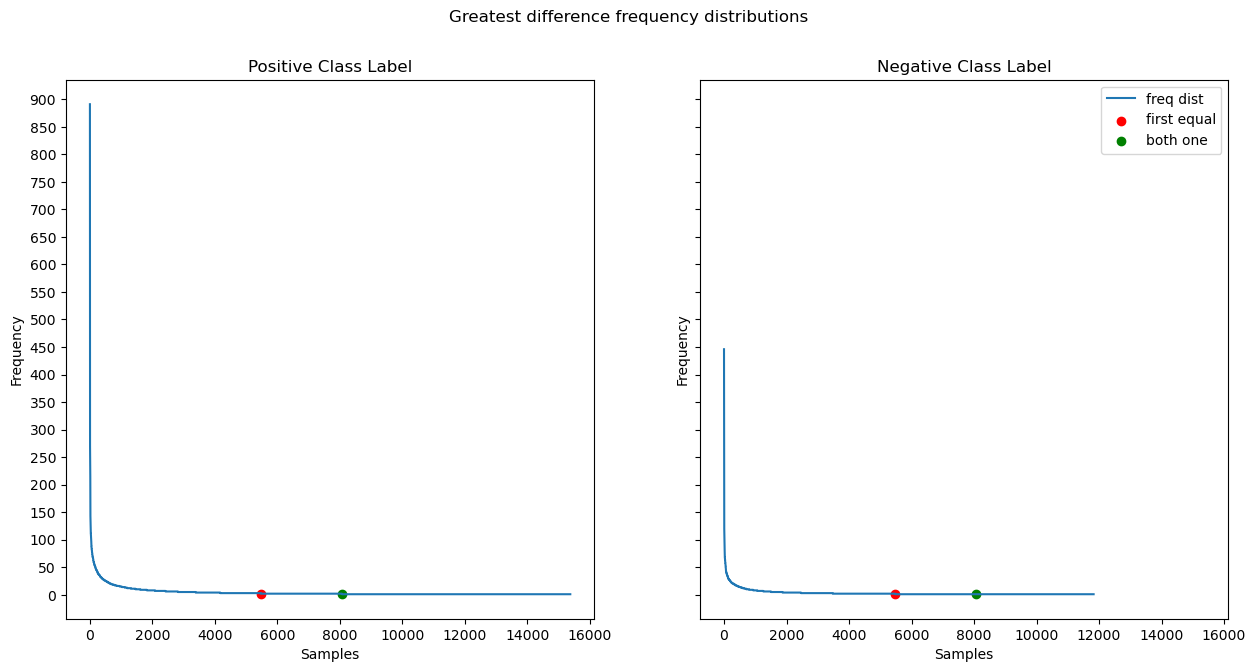

In [40]:
# Grab the class label freq dists and calculate their difference dists
posfreq, negfreq = freq_dists(training_norm)
pos_diff = difference(posfreq, negfreq)
neg_diff = difference(negfreq, posfreq)

# create subplots to show both distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharey=True, sharex=True)
fig.suptitle('Greatest difference frequency distributions')

# difference method returns a unordered frequency dist
# change to values()? 
pos_data = sorted(pos_diff.values(), reverse=True)
neg_data = sorted(neg_diff.values(), reverse=True)

# plot data in subplots
ax1.plot(pos_data) 
ax2.plot(neg_data)

# set subplots titles and axes
ax1.set_title('Positive Class Label')
ax2.set_title('Negative Class Label')
ax1.set_yticks(range(0,1000, 50))  # high precision y axes

# plot shared data
axes = [ax1, ax2]
equal_index, one_index = get_match(pos_data, neg_data)
for ax in axes:
    ax.scatter(equal_index[0], equal_index[1], color = 'r') #  where they become equal
    ax.scatter(one_index[0], one_index[1], color = 'g') #  where they both become one
    ax.set(xlabel='Samples', ylabel='Frequency') #  x and y labels

plt.legend(['freq dist', 'first equal', 'both one'])
plt.show()

The choice of the range of k was selected to see the effects of the frequencies of the words in the wordlist as they become less in each of the class label frequency distributions. As shown, the positive most frequent words contain 'film' which drags the intital y position to two times that of the negative. The fact that 'film' occurs nearly a thousand more in the postive class label documents would be significant if it was not ubiquitous in the negative documents aswell. Also, the positive has more hapax legomenon and a larger vocabulary size. The negative distribution curve plateaus before the positive distribution which will result in higher numbers of k producing more false positives. The upper range of k was chosen to be 1500 due to the little variation in frequency of the words beyond this point. If only occuring once or twice through all the documents then it is unlikely to have any effect on the score for classifying.

## Experiment:

In [44]:
ks = range(1,1500) # list of increasing k's
metric_data = [] # store metric data (acc,f1,precision,recall) for each k

for k in ks:
    # Instanciate and train classifier for given k
    wordlist_classifier = SimpleClassifier(k)
    wordlist_classifier.train(training_norm)
    
    # Predict classifier
    preds_test, gold = classifier_evaluate(wordlist_classifier, testing_norm)
    
    # Calculate and store metrics
    cm = ConfusionMatrix(preds_test, gold)
    metric_data.append([cm.get_all()])

### Results:

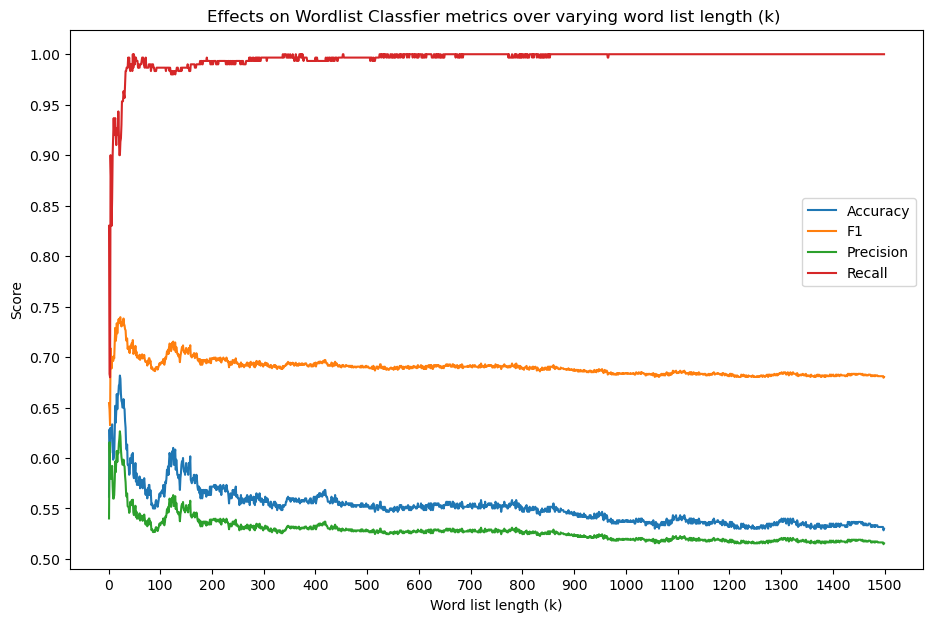

In [45]:
import numpy as np
metrics =  np.asarray(metric_data).squeeze() # reducing the dimensions
plt.figure(figsize=(11,7))
plt.plot(ks, metrics.squeeze())
plt.title('Effects on Wordlist Classfier metrics over varying word list length (k) ')
plt.yticks(np.linspace(0.5,1,11)) # higher precision y axes
plt.xticks(np.linspace(0, 1500, 16))
plt.xlabel('Word list length (k)')
plt.ylabel('Score')
plt.legend(['Accuracy','F1','Precision','Recall'], loc='upper right', bbox_to_anchor=(1, 0.7))
plt.show()

The results indicate significant impact on the classifiers accuracy, precision, and F1, with the classifier increasing its ability to classify negative documents as the word list increases from 10 to 50. As discussed previously, the positive word list contains some of the most frequents words in both class label frequency distributions. Hence, the shorter the word list the more effect this is going to have on the inability of the classifier to classify negative documents correctly, as can be seen when k is less than ten. Between 10 and 200, there is considerable shift in metric scores. An increase in precision, accuracy and F1 can be observed. Beyond 200 there is little change in any of the metrics, with precision and accuracy declining gradually as k increases. Recall shows little variation. It can be concluded that the sweet spot for the given wordlist classifier is between 20/30, where the words in the negative list have more effect in classification.

### Analysing best k for accuracy against initial k and Naive Bayes

In [52]:
best_k = np.argmax(metrics[:,0])+1 # collecting the index for max accuracy which gives us the k
wordlist_classifier = SimpleClassifier(best_k)
wordlist_classifier.train(training_norm) 
preds_test, gold = classifier_evaluate(wordlist_classifier, testing_norm)
wl_bestk_cm = ConfusionMatrix(preds_test, gold)
all_mets = display_metrics([wl_cm, wl_bestk_cm, nb_cm],
                             index = ['Wordlist Classifier (k=10)', 
                                      f'Worldlist Classifier (k={best_k})',
                                      'Naive Bayes Classifier'])
display(all_mets)

,accuracy,F1,precision,recall
Wordlist Classifier (k=10),0.596667,0.701235,0.556863,0.946667
Worldlist Classifier (k=22),0.690000,0.745205,0.632558,0.906667
Naive Bayes Classifier,0.786667,0.767273,0.844000,0.703333


In [53]:
bestk_matrix = wl_bestk_cm.get_matrix()
display(bestk_matrix)

,Negative,Positive
Negative,142,158
Positive,28,272


Upon using the k that produces the best accuracy, it's shown the classifier produces higher true negatives than when k = 10 but still struggles with false positives which is reflected in the low precision. The 10% increase in accuracy still does not reflect on the models ability to determine a positive sentiment effectively. The wordlist classifer has its precision and recall opposite in comparison to the Naive Bayes and results in both producing a similar F1 score.

## 5b: 

The limitation of a wordlist classifier is shown by the Naive Bayes use of words that occur less or hapax legomenon, indicating frequency of a word does not pertain to being more informative as to the sentiment of a review. The greatest frequency difference technique for generating the content words associated with the positive or negative sentiment label has issues when a word has high frequency in both classes of reviews but is more frequent in one. This creates a distortion in the word's importance in classifying the specific label that the word has be associated. The Naive Bayes is not task specific in terms of binary classification task but has the issue of assuming every word is independent from each other, language is complex and words are dependent upon one another to create meaning and context. The Naive Bayes is a solid starting point in classifying sentiment and can be tweaked through mathematical techniques to overcome the assumption of independence between features and thus create a more complex model of the data.

In [55]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437

import io
from nbformat import current

#filepath="/content/drive/My Drive/NLE Notebooks/assessment/assignment1.ipynb"
filepath="NLassignment2022.ipynb"
question_count=437

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 1671
